# Modelo KRR

Este notebook aplicará o algoritmo de KRR ao dataset obtido pelo xTB.

**Autor:** Edélio Gabriel Magalhães de Jesus.

<a id='sumario'></a>
## Sumário 

- [1) Introdução](#intro)
  - [1.1) Kernel Ridge Regression (KRR)](#sobre-krr)
  - [1.2) Diferenciando do modelo SVR](#semelhancas-svr)
  - [1.3) Objetivo do notebook](#objetivo)
- [2) Desenvolvimento do modelo](#desenvolvimento-modelo)
  - [2.1) Bibliotecas necessárias](#bibliotecas)
  - [2.2) Leitura dos dados](#leitura)
  - [2.3) Split dos dados](#split)
  - [2.4) Otimização do hiperparâmetros com o optuna](#optuna)
- [3) Treino e teste finais](#treino_final)
- [4) Interpretabilidade via SHAP](#interpretabilidade)
  - [4.1) O que é o SHAP?](#shap)
  - [4.2) Relação entre interpretabilidade e os modelos](#relacao)
- [5) Usando o SHAP](#usando_shap)
  - [5.1) Módulos necessários](#modulos)
  - [5.2) Avaliando o modelo](#avaliando_modelo)
  - [5.3) Summary plot](#summary)
  - [5.4) Bar plot](#barplot)
  - [5.5) Waterfall plot](#waterplot)
- [6) Conclusão](#conclu)
- [Referências](#ref)

<a id='intro'></a>
## 1) Introdução

<a id='sobre-krr'></a>
### **1.1) Kernel Ridge Regression (KRR)**

A **Kernel Ridge Regression (KRR)** combina conceitos da aprendizagem de máquina:

1. **Regressão Ridge** (regularização L2)  
2. **Truque do Kernel** (transformações não lineares implícitas)

**`Regressão Ridge`**

A **Regressão Ridge** é um tipo de regularização, especificamente a do tipo **L2**, caracterizada por penalizar a soma dos quadrados dos pesos [1]:

$$
  L_2: \;\; \lVert \mathbf{w} \rVert_2^2 \;=\; \sum_{j=1}^m w_j^2
$$

- **Efeito:** reduz o impacto de pesos muito grandes, mas dificilmente os torna exatamente zero.  
- **Uso típico:** útil quando todas as *features* contribuem um pouco para a predição.  
- **Interpretação:** reduz a **complexidade do modelo** ao “encolher” todos os pesos, evitando que um único parâmetro domine a predição.


**`Kernel trick`**

O **Truque do Kernel** (do inglês *kernel trick*) permite projetar os dados para um **espaço de características de dimensão muito alta (ou infinita)** sem precisar calcular explicitamente essa transformação [1].

Em vez de trabalhar com as variáveis originais $\mathbf{x}$, o modelo usa uma **função kernel** $K(\mathbf{x}_i, \mathbf{x}_j)$ que mede a similaridade entre pares de amostras. Assim, a solução final depende apenas desses produtos internos no espaço transformado. Alguns *kernels* comuns: linear, rbf, polinomial e sigmoide.

**`A formulação dual do KRR`**

Usando a forma dual, a solução da KRR é dada por [2]:

$$
\hat{\mathbf{y}} = K (K + \alpha I)^{-1} \mathbf{y}
$$

onde:

- $K$ é a matriz de kernel, com $K_{ij} = K(\mathbf{x}_i, \mathbf{x}_j)$  
- $\alpha$ é o parâmetro de regularização.

Essa forma dispensa o cálculo explícito de pesos $\mathbf{w}$ e se ajusta naturalmente a qualquer kernel definido positivo.

**`Parâmetros no sckit-learn`**

O módulo *sklearn* já disponibiliza uma classe para utilizar o algoritmo *KRR* na sua API [3]. Estes são os parâmetros disponibilizados para ajuste:

- `alpha`: força da regularização L2  
- `kernel`: tipo de kernel (`'linear'`, `'rbf'`, `'poly'`, `'sigmoid'`, etc.)  
- `gamma`: controla a largura do kernel RBF (ou o peso no kernel polinomial)  
- `degree`: grau do polinômio (quando `kernel='poly'`)  
- `coef0`: termo de deslocamento em kernels polinomial ou sigmoid  

<a id='semelhancas-svr'></a>
### **1.2) Diferenciando do modelo SVR**

O algoritmo de *KRR* se assemelha ao de *SVR* pelo uso de kernels para contornar relações não lineares entre as variáveis [3]. Existem , no entanto, algumas diferenças para se ressaltar:

| Aspecto | KRR | SVR |
|:--|:--|:--|
| Função de custo | Quadrática (erro médio + regularização L2) | Margem insensível ao erro (ε-insensitive loss) |
| Tipo de solução | Fechada (via inversão matricial) | Baseada em otimização convexa (programação quadrática) |
| Parâmetro principal | $\alpha$ (regularização) | $C$ (penalização) e $\epsilon$ (margem de tolerância) |
| Tempo de ajuste | Mais rápido e estável | Mais lento, especialmente em grandes datasets |
| Sensibilidade a outliers | Maior | Menor |
| Adequado para | Dados com ruído gaussiano | Casos com margens bem definidas |

![image](https://scikit-learn.org/stable/_images/sphx_glr_plot_kernel_ridge_regression_001.png)

**Fonte:** [scikit-learn](https://scikit-learn.org/stable/modules/kernel_ridge.html)


<a id='objetivo'></a>
### **1.3) Objetivo do notebook**

Diante disso, nosso objetivo será aplicar o algoritmo de *KRR*, utilizando o módulo *sklearn*, para realizar uma *task* de *regressão supervisionada* - realizando a otimização dos hiperparâmetros através do *optuna*.

[Voltar ao topo](#sumario)

<a id='desenvolvimento-modelo'></a>
## 2) Desenvolvimento do modelo

<a id='bibliotecas'></a>
### **2.1) Bibliotecas necessárias**

Antes de tudo, precisamos importar alguns módulos e funções específicas. São quatro bibliotecas principais:

1) **_pandas_**: para criação e manipulação de dataframes;  
2) **_numpy_**: para operações matemáticas e tratamento de arrays;  
3) **_plotly_**: para geração de gráficos interativos;  
4) **_sklearn_**: para implementação de modelos e ferramentas de *Machine Learning* (como divisão de dados, normalização e validação cruzada).  
5) **optuna**: para otimização dos hiperparâmetros

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import KFold
from optuna import create_study
from optuna.samplers import TPESampler, GPSampler
from optuna.pruners import HyperbandPruner
from optuna import Trial
from optuna.exceptions import TrialPruned
from optuna import load_study, trial
from concurrent.futures import ThreadPoolExecutor
import warnings
from sklearn.exceptions import ConvergenceWarning
import plotly.graph_objects as go
import plotly.express as px
import os


<a id='leitura'></a>
### **2.2) Leitura dos dados**

Vamos dar uma olhada no nosso dataset! Também visualizaremos algumas estatísticas de cada atributo, útil para as primeiras considerações.

In [ ]:
SEMENTE_ALEATORIA = 367

df = pd.read_csv('..\\dataset_processing\xtb_dataset.csv').sample(frac=0.1, random_state=SEMENTE_ALEATORIA)

df.describe()

Uma outra forma de visualizarmos as estatísticas é através do **`boxplot`**.

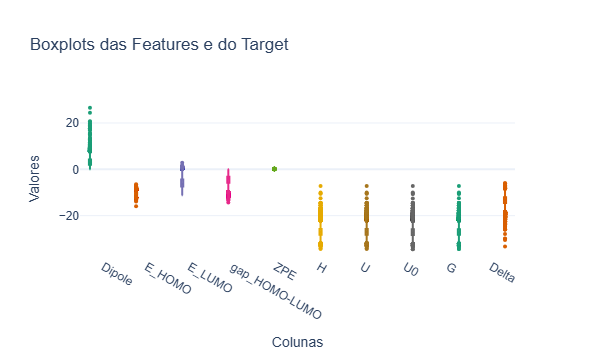

In [3]:
# Transformar para formato long
df_long = df.melt(var_name='Feature', value_name='Value')

# Criar boxplot 
fig = px.box(
    df_long, 
    x='Feature', 
    y='Value', 
    points='outliers',  # mostrar apenas outliers
    color='Feature',     # cores diferentes para cada feature
    title="Boxplots das Features e do Target",
    color_discrete_sequence=px.colors.qualitative.Dark2
)

# Ajustes estéticos
fig.update_layout(
    xaxis_title="Colunas",
    yaxis_title="Valores",
    boxmode='group',      # todos no mesmo eixo
    template='plotly_white',  # fundo branco limpo
    font=dict(family="Arial", size=12),
    showlegend=False
)

fig.update_traces(marker=dict(size=4))  # tamanho dos pontos outliers

fig.show()


Perceba que as escalas das *features* não são muito diferentes - com destaque para o *ZPE*, que possui valores muito pequenos em torno de 0 -, mas existem alguns *outliers*. 

O algoritmo *KRR* é bastante sensível à escala e valores extremos, justamente devido ao uso de *kernls* - como o *rbf*. Portanto, é importante que a normalização dos dados faça parte do nosso *pipeline*.

---

`Observação:` O gráfico foi plotado com *plotly*, que permite ampliar os gráfico - basta selecionar a área desejada.

<a id='split'></a>
### **2.3) Split dos dados**

A etapa de *split* no tratamento de dados consiste em `dividir` o conjunto de dados disponível em subconjuntos distintos: *`treinamento`* e *`teste`*. Essa divisão é importante para que o modelo de aprendizado de máquina seja treinado em uma parte dos dados e, posteriormente, avaliado em dados que ele nunca viu, garantindo uma medição justa de seu desempenho e evitando o *overfitting* - o ajuste excessivo aos dados de treinamento - e o *underfitting* - subestimação dos dados.

In [4]:
TAMANHO_TESTE = 0.2

X = df.drop(columns=['Delta'])
y = df['Delta']

X_treino, X_teste, y_treino, y_teste =train_test_split(X, y, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

Meste notebook, estaremos utilizando 80% dos dados para realizar o treino do modelo - via optuna - e 20% para a previsão - quando veremos o real desempenho do modelo com dados não vistos.

<a id='optuna'></a>
### **2.4) Otimização dos hiperparâmetros com o optuna**

#### **`Modelos e espaço de busca`**

A função `cria_instancia_modelo` abaixo serve para criar uma instância do modelo escolhido. Esta função recebe um objeto tipo *trial*; do `optuna`.

Observe que o dicionário `parametros` dentro desta função tem como chaves os nomes dos argumentos do modelo. Os valores dos argumentos, por sua vez, podem ser sorteados com as funções

-   `trial.suggest_int` (para números inteiros)
-   `trial.suggest_float` (para números reais) e
-   `trial.suggest_categorical` (para dados categóricos).

São com estas funções que delimitamos o **espaço de busca** dos hiperparâmetros do modelo.

Além dos parâmetros do modelo, estamos permitindo que o *optuna* decida se irá realizar os pré-processamentos de reduzir a dimensionalidade (via *PCA*).

In [13]:
def criar_instancia_modelo(trial, n_features):
    # Escolha do kernel
    kernel_escolhido = trial.suggest_categorical(
        "kernel", ["rbf", "poly", "linear", "laplacian"]
    )

    # Gamma contínuo para kernels baseados em distância
    gamma = trial.suggest_float("gamma", 1e-1, 1e1, log=True) if kernel_escolhido in ["rbf", "poly", "laplacian"] else 0.0

    # Alpha (regularização)
    alpha = trial.suggest_float("alpha", 1e-1, 1e2, log=True)

    coef0 = trial.suggest_float("coef0", 0.0, 10.0) if kernel_escolhido in ["poly", "sigmoid"] else 0.0

    # Grau do polinomial (somente se kernel == "poly")
    degree = trial.suggest_int("degree", 2, 4) if kernel_escolhido == "poly" else 3

    parametros_krr = {
        "alpha": alpha,
        "kernel": kernel_escolhido,
        "gamma": gamma,
        "degree": degree,
        "coef0": coef0,
    }

    # Flags do trial
    usar_pca = trial.suggest_categorical("usar_pca", [True, False])
    usar_sfs = trial.suggest_categorical("usar_sfs", [True, False])

    steps = []

    # Pipeline
    steps.append(("normalizador", StandardScaler()))

    if usar_sfs:
        forward = trial.suggest_categorical("sfs_forward", [True, False])
        n_features_to_select = trial.suggest_int("n_features_to_select", 1, 8)

        steps.append((
            "sfs",
            SequentialFeatureSelector(
                estimator=KernelRidge(**parametros_krr),
                n_features_to_select=n_features_to_select,
                direction="forward" if forward else "backward",
                scoring="neg_root_mean_squared_error",
                cv=3,
                n_jobs=1
            )
        ))

    # Decisão de aplicar PCA (apenas para kernels baseados em distância)
    if usar_pca and kernel_escolhido in ["rbf", "poly", "laplacian"]:
        n_comp = trial.suggest_float("variancia_pca", 0.85, 0.95)
        steps.append(("pca", PCA(n_components=n_comp, random_state=SEMENTE_ALEATORIA)))

    # Regressor KernelRidge
    steps.append(("regressor", KernelRidge(**parametros_krr)))

    modelo = Pipeline(steps=steps)

    return modelo

#### `Função objetivo`

A **função objetivo** em um problema de otimização é responsável por calcular a **métrica de desempenho** que será minimizada ou maximizada durante o processo.  

Neste caso, a métrica escolhida é o **RMSE (Root Mean Squared Error)**, obtido por meio de **validação cruzada**.

---

**Observação:**  
O *Python* (ou mais especificamente, algumas funções do `scikit-learn`) retorna valores **negativos** para métricas de erro quando configuradas para maximização.  
Por isso, é necessário **multiplicar por -1** antes de calcular a média dos valores de RMSE, garantindo que o algoritmo do Optuna minimize corretamente o erro.


In [16]:
def funcao_objetivo(trial, X, y, NUM_FOLDS=5):
    n_features = X.shape[1]
    modelo = criar_instancia_modelo(trial, n_features=n_features)

    cv = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEMENTE_ALEATORIA)
    rmse_folds = []

    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)

        rmse_folds.append(rmse)

        # Reporta progresso ao Optuna
        trial.report(np.mean(rmse_folds), step=i + 1)
        if trial.should_prune():
            raise TrialPruned()

    return np.mean(rmse_folds)

Vamos explorar um pouco mais sobre o uso da `Validação Cruzada Aninhada`.

---

A validação cruzada aninhada é uma técnica alternativa para avaliar o desempenho de um modelo de machine learning **quando também estamos ajustando hiper‑parâmetros** [7].  
Ela funciona por meio de **dois laços (loops)**:  
- **Laço externo (outer loop):** divide os dados em K folds para estimar o erro de generalização final do modelo.  
- **Laço interno (inner loop):** para cada subdivisão do laço externo, realiza uma nova validação cruzada (por exemplo usando `GridSearchCV`) para ajustar hiper‑parâmetros com os dados de treino desse fold externo.  

**Por que usar?**  
Se usarmos apenas uma validação cruzada simples para escolher hiper‑parâmetros *e* avaliar desempenho com o mesmo conjunto, corremos risco de obter estimativas excessivamente otimistas. A validação cruzada aninhada separa claramente a fase de seleção de modelos (*inner loop*) da fase de avaliação (*outer loop*) proporcionando estimativas menos enviesadas, minimizando o efeito de *overffiting*.

---

As duas funções abaixo realizam esse processo.


In [17]:
def cv_aninhado_fold(fold_idx, X, y, outer_splits, inner_splits, n_trials, pasta_estudos):
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=SEMENTE_ALEATORIA)

    for fold, (idx_train, idx_test) in enumerate(outer_cv.split(X, y)):
        if fold != fold_idx:
            continue

        print(f"\n Fold externo {fold + 1}/{outer_splits}")
        X_treino, X_teste = X.iloc[idx_train], X.iloc[idx_test]
        y_treino, y_teste = y.iloc[idx_train], y.iloc[idx_test]

        caminho_db = os.path.join(pasta_estudos, f"krr_fold_{fold + 1}.db")

        def inner_objective(trial):
            return funcao_objetivo(trial, X_treino, y_treino, NUM_FOLDS=inner_splits)

        study = create_study(
            study_name=f"krr_fold_{fold + 1}",
            direction="minimize",
            sampler=TPESampler(),
            pruner=HyperbandPruner(min_resource=1, max_resource=inner_splits, reduction_factor=2),
            storage=f"sqlite:///{caminho_db}",
            load_if_exists=True
        )

        # Ensaios iniciais para diversificar
        study.enqueue_trial({"usar_pca": False})
        study.enqueue_trial({"usar_pca": True})
        study.enqueue_trial({"usar_sfs": False})
        study.enqueue_trial({"usar_sfs": True})

        study.optimize(inner_objective, n_trials=n_trials, n_jobs=1, show_progress_bar=False)

        print("Melhores hiperparâmetros encontrados:")
        print(study.best_params)

        melhor_modelo = criar_instancia_modelo(study.best_trial, n_features=X_treino.shape[1])
        melhor_modelo.fit(X_treino, y_treino)

        y_pred = melhor_modelo.predict(X_teste)
        rmse_teste = root_mean_squared_error(y_teste, y_pred)
        print(f"→ RMSE de teste externo (fold {fold + 1}): {rmse_teste:.4f}")
        return rmse_teste

Esta função, em esecífico, faz com que os *outer trials* sejam executados paralelamente, cada um com seu próprio arquivo *.db*, a fim de buscar diminuir o tempo de execução.

#### **`Realizando o estudo`**

In [18]:
def cv_aninhado(X, y, outer_splits=3, inner_splits=5, n_trials=10, pasta_estudos="estudos_optuna_krr_final"):
    os.makedirs(pasta_estudos, exist_ok=True)
    outer_scores = []

    with ThreadPoolExecutor(max_workers=outer_splits) as executor:
        futures = [
            executor.submit(cv_aninhado_fold, fold, X, y, outer_splits, inner_splits, n_trials, pasta_estudos)
            for fold in range(outer_splits)
        ]
        for f in futures:
            outer_scores.append(f.result())

    print("\n========================")
    print("Resultados do Nested CV:")
    print(f"RMSE médio: {np.mean(outer_scores):.4f}")
    print(f"Desvio padrão: {np.std(outer_scores):.4f}")
    print("========================")

    return outer_scores

#### **`Realizando o estudo`**

In [ ]:
resultados = cv_aninhado(
    X_treino, y_treino,
    outer_splits=3,
    inner_splits=5,
    n_trials=100
)

O estudo foi realizado, agora precisamos obter o melhor estudo dentre todos os estudos de cada *fold* externo e, posteriormente, o melhor entre os melhores.

In [12]:
import os

pasta_estudos = "estudos_optuna_krr_final"
arquivos_db = [f for f in os.listdir(pasta_estudos) if f.endswith(".db")]

print("Arquivos .db encontrados:")
for f in arquivos_db:
    print("-", f)


Arquivos .db encontrados:
- krr_fold_1.db
- krr_fold_2.db
- krr_fold_3.db


In [13]:
resultados = []

for arquivo in arquivos_db:
    caminho = os.path.join(pasta_estudos, arquivo)
    # Ajuste conforme descoberto no passo anterior
    study_name = arquivo.replace("krrr_fold", "krr_fold").replace(".db", "")
    
    try:
        study = load_study(study_name=study_name, storage=f"sqlite:///{caminho}")
        best_trial = study.best_trial
        
        print(f"✅ {study_name}")
        print(f"  Melhor valor: {best_trial.value:.7f}")
        print(f"  Parâmetros: {best_trial.params}\n")
        
        resultados.append({
            "fold": study_name,
            "melhor_valor": best_trial.value,
            "params": best_trial.params
        })
    except Exception as e:
        print(f"Não foi possível carregar {study_name}: {e}")

# Criar resumo
if resultados:
    df = pd.DataFrame(resultados)
    display(df)
    print(f"RMSE médio: {np.mean(df['melhor_valor']):.7f}")
    print(f"Desvio padrão: {np.std(df['melhor_valor']):.7f}")
else:
    print("Nenhum estudo pôde ser carregado.")


✅ krr_fold_1
  Melhor valor: 0.0000075
  Parâmetros: {'kernel': 'poly', 'gamma': 4.417659195729214, 'alpha': 0.15205393395994812, 'coef0': 4.379906035822025, 'degree': 3, 'usar_pca': False, 'usar_sfs': True, 'sfs_forward': True, 'n_features_to_select': 3}

✅ krr_fold_2
  Melhor valor: 0.0000413
  Parâmetros: {'kernel': 'poly', 'gamma': 9.658751693187039, 'alpha': 0.6436141444506221, 'coef0': 3.6834639296816234, 'degree': 4, 'usar_pca': False, 'usar_sfs': True, 'sfs_forward': False, 'n_features_to_select': 3}

✅ krr_fold_3
  Melhor valor: 0.0000896
  Parâmetros: {'kernel': 'poly', 'gamma': 9.716478251058609, 'alpha': 0.8694661519971489, 'coef0': 7.24613924986782, 'degree': 3, 'usar_pca': False, 'usar_sfs': True, 'sfs_forward': False, 'n_features_to_select': 7}



fold  melhor_valor                                             params
0  krr_fold_1      0.000007  {'kernel': 'poly', 'gamma': 4.417659195729214,...
1  krr_fold_2      0.000041  {'kernel': 'poly', 'gamma': 9.658751693187039,...
2  krr_fold_3      0.000090  {'kernel': 'poly', 'gamma': 9.716478251058609,...

RMSE médio: 0.0000461
Desvio padrão: 0.0000337


In [14]:
# df já contém os melhores trials de cada fold
melhor_fold = df.loc[df['melhor_valor'].idxmin()]  # menor RMSE
print("Melhor fold:", melhor_fold['fold'])
print("Melhor valor:", melhor_fold['melhor_valor'])
print("Melhores parâmetros:", melhor_fold['params'])

Melhor fold: krr_fold_1
Melhor valor: 7.450943783132653e-06
Melhores parâmetros: {'kernel': 'poly', 'gamma': 4.417659195729214, 'alpha': 0.15205393395994812, 'coef0': 4.379906035822025, 'degree': 3, 'usar_pca': False, 'usar_sfs': True, 'sfs_forward': True, 'n_features_to_select': 3}


In [10]:
resultados = []

for arquivo in arquivos_db:
    caminho = os.path.join(pasta_estudos, arquivo)
    # Ajuste conforme descoberto no passo anterior
    study_name = arquivo.replace("krr_fold", "krr_fold").replace(".db", "")
    
    try:
        study = load_study(study_name=study_name, storage=f"sqlite:///{caminho}")
        best_trial = study.best_trial
        
        print(f"✅ {study_name}")
        print(f"  Melhor valor: {best_trial.value:.7f}")
        print(f"  Parâmetros: {best_trial.params}\n")
        
        resultados.append({
            "fold": study_name,
            "melhor_valor": best_trial.value,
            "params": best_trial.params
        })
    except Exception as e:
        print(f"⚠️ Não foi possível carregar {study_name}: {e}")

# Criar resumo
if resultados:
    df = pd.DataFrame(resultados)
    display(df)
    print(f"RMSE médio: {np.mean(df['melhor_valor']):.7f}")
    print(f"Desvio padrão: {np.std(df['melhor_valor']):.7f}")
else:
    print("Nenhum estudo pôde ser carregado.")


✅ krr_fold_3
  Melhor valor: 0.0000896
  Parâmetros: {'kernel': 'poly', 'gamma': 9.716478251058609, 'alpha': 0.8694661519971489, 'coef0': 7.24613924986782, 'degree': 3, 'usar_pca': False, 'usar_sfs': True, 'sfs_forward': False, 'n_features_to_select': 7}

✅ krr_fold_2
  Melhor valor: 0.0000413
  Parâmetros: {'kernel': 'poly', 'gamma': 9.658751693187039, 'alpha': 0.6436141444506221, 'coef0': 3.6834639296816234, 'degree': 4, 'usar_pca': False, 'usar_sfs': True, 'sfs_forward': False, 'n_features_to_select': 3}

✅ krr_fold_1
  Melhor valor: 0.0000075
  Parâmetros: {'kernel': 'poly', 'gamma': 4.417659195729214, 'alpha': 0.15205393395994812, 'coef0': 4.379906035822025, 'degree': 3, 'usar_pca': False, 'usar_sfs': True, 'sfs_forward': True, 'n_features_to_select': 3}



fold  melhor_valor                                             params
0  krr_fold_3      0.000090  {'kernel': 'poly', 'gamma': 9.716478251058609,...
1  krr_fold_2      0.000041  {'kernel': 'poly', 'gamma': 9.658751693187039,...
2  krr_fold_1      0.000007  {'kernel': 'poly', 'gamma': 4.417659195729214,...

RMSE médio: 0.0000461
Desvio padrão: 0.0000337


In [11]:
# df já contém os melhores trials de cada fold
melhor_fold = df.loc[df['melhor_valor'].idxmin()]  # menor RMSE
print("Melhor fold:", melhor_fold['fold'])
print("Melhor valor:", melhor_fold['melhor_valor'])
print("Melhores parâmetros:", melhor_fold['params'])


Melhor fold: krr_fold_1
Melhor valor: 7.450943783132653e-06
Melhores parâmetros: {'kernel': 'poly', 'gamma': 4.417659195729214, 'alpha': 0.15205393395994812, 'coef0': 4.379906035822025, 'degree': 3, 'usar_pca': False, 'usar_sfs': True, 'sfs_forward': True, 'n_features_to_select': 3}


O melhor modelo encontrado aplicou os seguintes processos e parâmetros:

- AplicaR de seleção de atributos: com SequencialFeatureSelection(), selecioando apenas 3 *features* e no modo *forward* - adicionando ao invés de retirar;

- Aplicar o KNN com os parâmetros:
 - **Kernel: polinomial**  
    O kernel polinomial permite modelar relações **não lineares** entre as variáveis de entrada e a variável alvo. Ele projeta os dados em um espaço de características de dimensão superior, tornando possível ajustar funções curvas e complexas.

  - **Degree: 3**  
    O grau do polinômio define o nível de curvatura que o modelo pode representar. Um grau 3 permite capturar interações cúbicas entre as variáveis, fornecendo flexibilidade moderada sem tornar o modelo excessivamente complexo.

  - **Gamma: 4.4177**  
    O parâmetro `gamma` controla a influência de cada amostra sobre o ajuste. Aqui, o valor alto de `gamma` indica um modelo com alta sensibilidade às estruturas locais do conjunto de treino.

  - **Alpha: 0.1521**  
    O `alpha` é o termo de regularização que controla o equilíbrio entre ajuste aos dados e suavidade da solução. Um valor moderado, como 0.15, evita sobreajuste, penalizando coeficientes grandes sem eliminar completamente a capacidade de adaptação do modelo.

  - **Coef0: 4.3799**  
    O `coef0` afeta a contribuição dos termos de baixa ordem no kernel polinomial. Um valor elevado aumenta a influência das interações lineares e quadráticas em relação às cúbicas, resultando em uma superfície de regressão mais equilibrada e menos propensa a oscilações extremas.

Assim, conforme o estudo do *optuna*, nosso melhor modelo "decidiu" trabalhar com as relações não lineares ddos dados.


[Voltar ao topo](#sumario)

<a id='treino_final'></a>
## 3) Treino e teste finais

In [6]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


SEMENTE_ALEATORIA = 367

TAMANHO_TESTE=0.2
df_final = pd.read_csv('../dataset_processing/xtb_dataset.csv').sample(frac=0.1, random_state=SEMENTE_ALEATORIA)

X = df_final.drop(columns=['Delta'])
y = df_final['Delta']

# Divisão dos dados
X_treino_final, X_teste_final, y_treino_final, y_teste_final = train_test_split(
    X, y, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

# Modelo Kernel Ridge com os melhores parâmetros
krr_model = KernelRidge(
    kernel='poly',
    gamma=4.417659195729214,
    alpha=0.15205393395994812,
    coef0=4.379906035822025,
    degree=3
)

# Sequential Feature Selector com os mesmos parâmetros
sfs = SequentialFeatureSelector(
    estimator=KernelRidge(
        kernel='poly',
        gamma=4.417659195729214,
        alpha=0.15205393395994812,
        coef0=4.379906035822025,
        degree=3
    ),
    n_features_to_select=3,
    direction='forward'  # sfs_forward=True -> forward
)

# Pipeline completo
pipe_final = Pipeline([
    ("normalizador", StandardScaler()),  # Normalização opcional
    ("seletor", sfs),
    ("estimator", krr_model)
])

# Treinamento
pipe_final.fit(X_treino_final, y_treino_final)

# Recuperar nomes das features selecionadas
selected_features = X_treino_final.columns[sfs.get_support()]
print("Features selecionadas:", list(selected_features))


Features selecionadas: ['Dipole', 'ZPE', 'U0']


Aqui, confirmamos quais features foram selecionadas: **Dipole**, **ZPE**, **U0**.

---

Vamos seguir com o teste, via validação cruzada.

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Número de folds
CV_FOLDS = 5

# Avaliação do pipeline com cross-validation
scores = cross_val_score(
    pipe_final,      # pipeline já inclui SFS e KRR
    X_teste_final,  # conjunto de treino
    y_teste_final,
    cv=CV_FOLDS,     # quantidade de folds
    scoring='neg_root_mean_squared_error'     # métrica de avaliação, aqui RMSE
)

In [9]:
# Resultado médio e desvio padrão
print(f"RMSE médio: {-np.mean(scores):.7f}")
print(f"Desvio padrão: {np.std(scores):.7f}")

RMSE médio: 0.0000054
Desvio padrão: 0.0000008


Tivemos um RMSE extremamente baixo, com grandeza na ordem de $10^{-6}$. Isso a princípio é muito bom, mas devemos sempre considerar outros fatores, como possível *overffting*. Mas considerando que utilizamos uma validação cruzada aninhada, justamente para evitar um sobreajuste, e testamos com dados não visto pelo modelo, podemos dar um voto de confiança para o seu desempenho.

[Voltar ao topo](#sumario)

<a id='interpretabilidade'></a>
## 4) Interpretabilidade via SHAP

<a id='shap'></a>
### **4.1) O que é o *SHAP***

![image](https://shap.readthedocs.io/en/latest/_images/shap_header.png)

**Fonte:** [SHAP](https://shap.readthedocs.io/en/latest/)

O *SHAP (SHapley Additive exPlanations)* é uma abordagem baseada em teoria dos jogos para explicar a saída de qualquer modelo de aprendizado de máquina (“black-box”). 

O conceito central deriva dos valores de `Lloyd Shapley (Shapley values)`, originalmente desenvolvidos em jogos cooperativos, para distribuir “créditos” aos jogadores conforme suas contribuições marginais.

No contexto de modelos de ML, cada “jogador” é um *feature* (variável) ou valor de feature, e o “prêmio” do jogo é o valor de predição do modelo menos um valor de referência (por exemplo, a média da predição). 

[Voltar ao topo](#sumario)

<a id='relacao'></a>
### **4.2) Relação com a interpretabilidade de modelos**

Em muitos cenários de aprendizado de máquina, especialmente em modelos de alta complexidade (como ensembles, redes neurais…), temos alta acurácia mas baixa transparência (“caixa-preta”). SHAP ajuda a reduzir essa lacuna ao oferecer explicações compreensíveis para as previsões. Permite responder perguntas como: *Quais features mais contribuíram para esta previsão?* ou *Para um dado cliente, quais variáveis “empurraram” a predição para cima ou para baixo?*

Pode também ajudar na visão global do modelo: agregando valores SHAP sobre muitas instâncias, conseguimos visualizar quais features têm geralmente mais impacto nas previsões, detectar dependências ou interações, e até investigar vieses ou decisões inesperadas.

**Como funciona em termos gerais**  
1. Para uma dada instância de entrada $x$, o modelo prediz $f(x)$.  
2. A ideia é computar quanto cada feature contribui para essa predição, comparada à previsão média $\mathbb{E}[f(X)]$.  
3. Para cada feature $j$, consideram-se todas (ou muitas) as combinações possíveis de features que a precedem (coalitions). Para cada coalizão $S \subseteq \{1, \dots, p\} \setminus \{j\}$, mede-se a “valoração” $v(S \cup \{j\}) - v(S)$ — ou seja, a diferença de predição se incluirmos $j$ ou não. A média desta diferença (ponderada apropriadamente) dá o valor SHAP $\phi_j$.  
4. As contribuições $\phi_j$ de todas as features somam-se exatamente à diferença $f(x) - \mathbb{E}[f(X)]$. Essa é a propriedade de **eficiência**.  

**Propriedades importantes que tornam SHAP útil para interpretabilidade**  

- **Localidade**: SHAP explica *uma predição individual* (instância $x$), o que é muito relevante quando queremos entender “por que esse cliente foi aceito ou recusado?”.
  
- **Aditividade / Eficiência**: A soma das contribuições das features corresponde à diferença entre a predição e o valor médio, garantindo que nenhuma “parte” da explicação se perca.   
  
- **Consistência**: Em teoria, se o modelo altera-se de modo que a contribuição de um feature aumente, então seu valor SHAP não diminui — isso faz com que a explicação seja “justa” em termos de atribuição.  
  
- **Modelo-agnóstico (até certo ponto)**: SHAP pode ser aplicado a muitos tipos de modelos (regressão, árvores de decisão, redes neurais…) porque trata das features como “jogadores” sem depender fortemente da estrutura do modelo. 

[Voltar ao topo](#sumario)

<a id='usando_shap'></a>
## 5) Usando o SHAP

<a id='modulos'></a>
### **5.1) Módulos necessários**

Antes de tudo, certifique-se de ter instalado o módulo `shap`.

---

````python
pip install shap
````
---

In [15]:
import shap

<a id='avaliando_modelo'></a>
### **5.2 Avaliando o melhor modelo**

Para analisar a interpretabilidade utilizareoms o modelo vencedor encontrado pelo *Optuna* - já instanciado na seção anterior.

**Observação importante:** O *SHAP* não aceita um pipeline completo como entrada, ele requer um modelo final ou uma função de predição. 

Além disso, o modelo não é definido apenas pelos hiperparâmetros do algoritmo (`KRR`), mas também inclui todas as etapas de pré-processamento do pipeline, como `StandardScaler`, `SFS` ou `PCA`. Essas transformações devem ser aplicadas corretamente antes de calcular os valores de SHAP, garantindo que a explicação reflita exatamente como o modelo processa os dados.


In [ ]:
X_treino_sel = X_treino_final[selected_features]
X_teste_sel = X_teste_final[selected_features]

explainer = shap.Explainer(krr_model.predict, X_treino_sel)
shap_values = explainer(X_teste_sel)

c:\Users\edelio25024\OneDrive - ILUM ESCOLA DE CIÊNCIA\VSCODE\R2D2_MACHINE_LEARNING\R2D2\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KernelRidge was fitted without feature names
  warnings.warn(
c:\Users\edelio25024\OneDrive - ILUM ESCOLA DE CIÊNCIA\VSCODE\R2D2_MACHINE_LEARNING\R2D2\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KernelRidge was fitted without feature names
  warnings.warn(
c:\Users\edelio25024\OneDrive - ILUM ESCOLA DE CIÊNCIA\VSCODE\R2D2_MACHINE_LEARNING\R2D2\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KernelRidge was fitted without feature names
  warnings.warn(
c:\Users\edelio25024\OneDrive - ILUM ESCOLA DE CIÊNCIA\VSCODE\R2D2_MACHINE_LEARNING\R2D2\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KernelRidge was fitted without feature names
  warnings.warn(
c:\Users\ede

Agora, vamos aos *plots*!

<a id='summary'></a>
### **5.3 Summary plot**

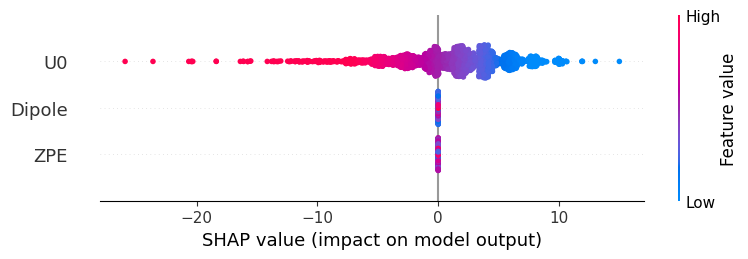

In [21]:
shap.summary_plot(shap_values.values, features=X_teste_sel, feature_names=selected_features)


Antes de tudo, perceba novamente que o melhor modelo resultou em uma seleção de apenas 3 dos 9 atributos do conjunto de dados original.

---

O gráfico acima é um **SHAP summary plot**, uma forma de visualizar a importância e o efeito das variáveis em um modelo preditivo.  
Cada ponto representa uma observação (amostra do conjunto de dados), e sua posição no eixo horizontal indica o **impacto da feature no output do modelo** — isto é, o quanto aquela variável contribuiu para aumentar ou diminuir a predição.

O gráfico acima representa o impacto das três *features* — **U0**, **Dipole** e **ZPE** — sobre a saída do modelo, medido pelos valores SHAP (*SHapley Additive exPlanations*).  
Cada ponto representa uma amostra, com a cor indicando o valor da *feature* (rosa = alto, azul = baixo).


`Análise geral`

- **Eixo X (SHAP value)**: mostra o quanto cada *feature* contribui para aumentar (valores positivos) ou diminuir (valores negativos) a predição do modelo.
- **Eixo Y (features)**: ordena as variáveis por importância média (impacto absoluto dos valores SHAP).
- **Cores**: representam o valor real da *feature* — tons quentes (rosa/vermelho) indicam valores altos, e tons frios (azul) indicam valores baixos.

`Interpretação por *feature*`

1. **U0 (energia interna)**  
   - É a variável mais importante do modelo.  
   - Observa-se uma ampla dispersão de valores SHAP, especialmente negativos, indicando forte impacto sobre a saída.  
   - Valores altos de U0 (rosa) tendem a diminuir fortemente a predição, enquanto valores baixos (azul) têm efeito oposto, aumentando-a.

2. **Dipole (momento dipolar)**  
   - Possui impacto pequeno e concentrado próximo de zero.  
   - As variações dessa *feature* não alteram significativamente o resultado do modelo.  
   - Isso sugere que o momento dipolar tem baixa relevância para o fenômeno sendo modelado.

3. **ZPE (Zero Point Energy)**  
   - Também apresenta impacto mínimo, similar ao do *Dipole*.  
   - A distribuição estreita ao redor de zero indica baixa sensibilidade do modelo a essa variável.

Assim, o modelo baseia-se fortemente na variável **U0** para suas previsões, enquanto **Dipole** e **ZPE** contribuem muito pouco.  
Em termos físicos, isso indica que a **energia interna (U0)** é o fator determinante no comportamento que o modelo está aprendendo, possivelmente refletindo uma relação direta com o alvo energético previsto.

**Insight científico:**  
A predominância de U0 sugere que o modelo está captando relações energéticas diretas — por exemplo, a contribuição de estados eletrônicos ou correlações entre energia interna e outras propriedades moleculares — enquanto as propriedades mais sutis (como o dipolo e ZPE) não exercem influência significativa neste contexto.

<a id='barplot'></a>
### **5.4 Bar plot**

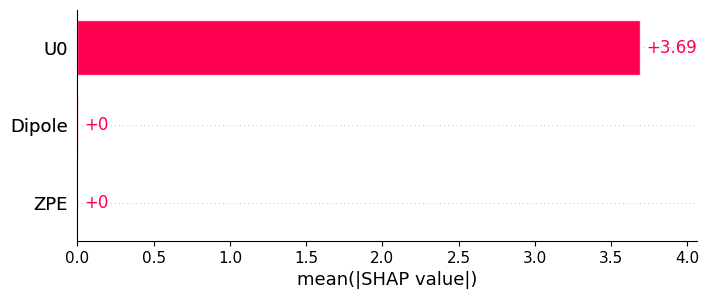

In [22]:
shap.plots.bar(shap_values)

O gráfico acima mostra a **importância média das variáveis** no modelo, calculada pela média dos valores absolutos de SHAP (`mean(|SHAP value|)`).  
Ele representa, em termos quantitativos, **o quanto cada *feature* contribui em média para as variações das previsões**.

`Estrutura do gráfico`
- **Eixo X:** magnitude média dos valores SHAP — quanto maior, maior o impacto da *feature* no resultado.  
- **Eixo Y:** lista das *features* avaliadas.  
- **Cor e anotação à direita:** indicam o valor numérico do impacto médio.

`Interpretação detalhada`

1. **U0 (energia interna)**  
   - Apresenta o maior valor médio de |SHAP| (≈ **3.69**), destacando-se de forma absoluta em relação às demais.  
   - Isso confirma que **U0 é a variável dominante** na determinação das previsões do modelo.  
   - Em termos práticos, pequenas variações em U0 produzem grandes alterações na saída prevista, reforçando sua relevância física.

2. **Dipole (momento dipolar)**  
   - Possui impacto médio praticamente nulo (**≈ 0**).  
   - O modelo praticamente ignora essa variável durante as predições.

3. **ZPE (Zero Point Energy)**  
   - Também apresenta contribuição média nula (**≈ 0**), indicando irrelevância para o modelo.


Assim, pelos resultados, modelo se apoia **quase exclusivamente na variável U0**, enquanto as demais *features* não exercem influência mensurável sobre as predições.  
Esse resultado reforça a evidência observada no *summary plot*: **U0 domina a explicação das variações do alvo**, e a inclusão de *Dipole* e *ZPE* não melhora a capacidade preditiva do modelo.

<a id='waterplot'></a>
### **5.5) Waterfall plot**

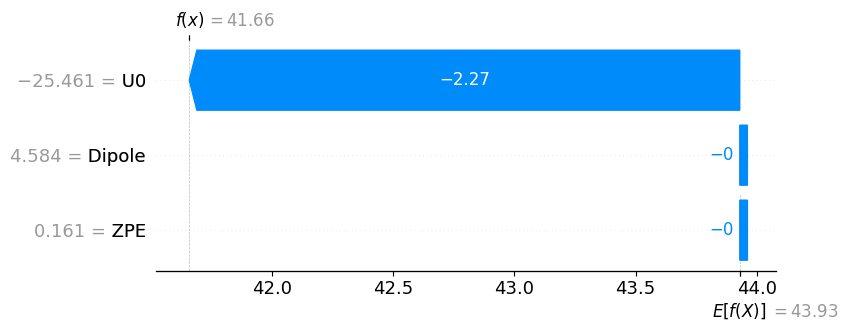

In [26]:
shap.plots.waterfall(shap_values[0])

O gráfico acima é um **waterfall plot** do SHAP, que mostra **como cada *feature* contribui individualmente** para a predição de uma amostra específica do modelo.

`Estrutura do gráfico`

- **E[f(X)] = 43.93** → é o valor médio das predições do modelo (baseline).  
- **f(x) = 41.66** → é a predição final para esta amostra.  
- As barras mostram como cada *feature* desloca o valor da predição em relação à média.  
  - **Azul**: contribuição negativa (reduz o valor previsto).  
  - **Vermelho** (não há aqui): contribuição positiva (aumentaria o valor previsto).

`Interpretação`

1. **U0 = -25.461 → impacto = -2.27**  
   - É a variável que mais influenciou a predição.  
   - Seu valor negativo levou a uma **redução de 2.27 unidades** no resultado final em relação à média do modelo.  
   - Isso reforça o padrão visto nos gráficos anteriores: **valores baixos de U0** reduzem fortemente a saída predita.

2. **Dipole = 4.584 → impacto ≈ 0**  
   - O momento dipolar praticamente **não alterou a predição**.  
   - Sua influência é estatisticamente insignificante neste caso.

3. **ZPE = 0.161 → impacto ≈ 0**  
   - Também não contribuiu de forma relevante para o resultado final.

A predição **f(x) = 41.66** resulta principalmente da influência da variável **U0**, que deslocou a estimativa média (43.93) para baixo.  
As demais *features* (**Dipole** e **ZPE**) tiveram efeito desprezível sobre a saída.


[Voltar ao topo](#sumario)

<a id='conclu'></a>
## 6) Conclusão

Neste notebook conseguimos explorar o conceito de **interpretabilidade** em modelo de Machine Learning.

Utilizando o módulo *SHAP*, analisamos o melhor modelo do algoritmo *Kernel Ridge Regression* obtido pelo estudo via *optuna*, explorando aspectos quantitativos e qualitativos, compreeendendo melhor como os atributos selecionados contruiram indidual e coletivamente para as previsões.

Compreender como modelos de ML realizam suas previsões está se tornado cada vez mais almejado, principalmente em contextos onde a simples predição não é suficiente - como em diagnósticos clínicos, nos quais é importante entender como se chegou a determinada conclusão.

[Voltar ao topo](#sumario)

<a id='ref'></a>
## Referências 

[1] **Livro**: RASCHKA, Sebastian; MIRJALILI, Vahid. *Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2*. 3. ed. Packt, [s.d.].  

[2] **Documento de aula:** Carnegie Mellon University - Bartlett, P. (2008). Kernel ridge regression, Gaussian processes, and ensemble methods (Lecture 10, CS 281B/Stat 241B, Spring 2008). Scribe : Kevin Canini. Universidade da Califórnia, Berkeley. Disponível em: [https://people.eecs.berkeley.edu/~bartlett/courses/281b-sp08/10.pdf](https://people.eecs.berkeley.edu/~bartlett/courses/281b-sp08/10.pdf)

[3] **Documentação:** sklearn - [Kernel Ridge Regression](https://scikit-learn.org/stable/modules/kernel_ridge.html)

**Site:** IMB - [Regressão de Kernel Ridge](https://www.ibm.com/docs/pt-br/spss-statistics/30.0.0?topic=statistics-kernel-ridge-regression)

[Voltar ao topo](#sumario)